In [1]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import torch
import torchvision

In [2]:
torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.get_device_name()

(True, 1, 'NVIDIA GeForce RTX 2060')

In [3]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

def accuracy(predicted_logits, reference):
    """
    Compute the ratio of correctly predicted labels
    
    @param predicted_logits: float32 tensor of shape (batch size, num classes)
    @param reference: int64 tensor of shape (batch_size) with the class number
    """
    labels = torch.argmax(predicted_logits, 1)
    correct_predictions = labels.eq(reference)
    return correct_predictions.sum().float() / correct_predictions.nelement()

In [4]:
# Loaded a set of images
root_dir = "data/training/"
image_test = "data/test_set_images"
image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(50, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = 40 # Only use 10 images for training

Loading 50 images
satImage_001.png
Loading 50 images
satImage_001.png


Image size = 400,400


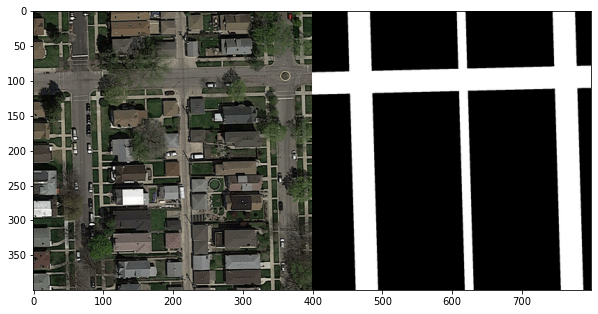

In [5]:
%matplotlib inline
i=5
print('Image size = ' + str(imgs[i].shape[0]) + ',' + str(imgs[i].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[i], gt_imgs[i])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [6]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [7]:
###IGNORE####
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    return X
#####IGNORE END##### 

In [8]:
DATA_DIR = 'data'

x_train_dir = os.path.join(DATA_DIR, 'training/images')
y_train_dir = os.path.join(DATA_DIR, 'training/groundtruth')

#x_valid_dir = os.path.join(DATA_DIR, 'val')
#y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test_set_images')
#y_test_dir = os.path.join(DATA_DIR, 'test_labels')

class RoadsDataset(torch.utils.data.Dataset):

    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
    ):        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]
    
    def __getitem__(self, i):
        
        #Transformation, used for data augmentation
        transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()])
        
        # read images and masks
        image = mpimg.imread(self.image_paths[i])
        mask = mpimg.imread(self.mask_paths[i])
        
        #image = self.transform(image)
        #mask = self.transform(mask)
        
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

In [9]:
class RoadsDataset(torch.utils.data.Dataset):

    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            X, 
            y, 
    ):        
        self.X = X
        self.y = y
    
    def __getitem__(self, i):
        
        # read images and masks        
        image = self.X[i]
        X = self.transform(image)
        mask = self.y[i]#.reshape(2)
        #y = self.transform(mask)
        y = torch.from_numpy(np.asarray(mask))#.long()
        #y = torch.unsqueeze(y, 0)
        return X, y
        
        return image, mask
    
    #Transformation, used for data augmentation
    transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])
        
    def __len__(self):
        # return length of 
        return len(self.X)

In [10]:
class RoadsTestset(torch.utils.data.Dataset):

    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            X, 
    ):        
        self.X = X
    
    def __getitem__(self, i):
        
        # read images and masks        
        image = self.X[i]
        X = self.transform(image)
        #X = torch.permute(X, (2, 0, 1, ))
        return X
        
        return image
    
    #Transformation, used for data augmentation
    transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])
        
    def __len__(self):
        # return length of 
        return len(self.X)

In [11]:
gt_patches.shape

(25000, 16, 16)

In [14]:
batch_size = 1000
dataset_train = torch.utils.data.DataLoader(RoadsDataset(img_patches, Y), batch_size=batch_size, shuffle=True)
dataset_test = torch.utils.data.DataLoader(RoadsTestset(img_patches), batch_size=10, shuffle=True)
#random_idx = np.random.randint(0, len(dataset_train)-1)
#image, mask = dataset_train[random_idx]

#image.shape, mask.shape, 
len(dataset_train)

#cimg = concatenate_images(image, mask)
#fig1 = plt.figure(figsize=(10, 10))
#plt.imshow(cimg, cmap='Greys_r')

25

In [15]:
class LeNetModel(torch.nn.Module):
  def __init__(self):
    """From: LeCun et al., 1998. Gradient-Based Learning Applied to Document Recognition"""
    super().__init__()
    self.conv1 = torch.nn.Conv2d(3, 10, kernel_size=5)
    self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = torch.nn.Dropout2d(0.5)
    self.fc1 = torch.nn.Linear(20, 5)
    self.fc2 = torch.nn.Linear(5, 2)

  def forward(self, x):
    relu = torch.nn.functional.relu
    max_pool2d = torch.nn.functional.max_pool2d

    x = relu(max_pool2d(self.conv1(x), 2))
    x = relu(max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(batch_size, -1)
    x = relu(self.fc1(x))
    x = torch.nn.functional.dropout(x, training=self.training)
    x = self.fc2(x)
    return x # Previously there was torch.nn.functional.log_softmax(x, dim=1) here which was incorrect (although the network could still train)

train_data = []
for i in range(len(img_patches)):
   train_data.append([img_patches[i], gt_patches[i]])

# Split into train set and validation set
#train_subset, val_subset = torch.utils.data.random_split(
#        train_data, [50000, 10000], generator=torch.Generator().manual_seed(1))

#train_data = train_data.ToTensor()
train_data.permute(1, 3)

dataset_train = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=100)
i1, l1 = next(iter(trainloader))
print(i1.shape)



In [16]:
def train(model, criterion, dataset_train, dataset_test, optimizer, num_epochs):
  """
  @param model: torch.nn.Module
  @param criterion: torch.nn.modules.loss._Loss
  @param dataset_train: torch.utils.data.DataLoader
  @param dataset_test: torch.utils.data.DataLoader
  @param optimizer: torch.optim.Optimizer
  @param num_epochs: int
  """
  print("Starting training")
  for epoch in range(num_epochs):
    # Train an epoch
    model.train()
    for batch_x, batch_y in dataset_train:
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)


      prediction = model(batch_x)
      #print(prediction.shape, batch_y.shape)
      loss = criterion(prediction, batch_y)
    
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


    # Test the quality on the test set
    model.eval()
    accuracies_test = []
    for batch_x, batch_y in dataset_test:
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)

      # Evaluate the network (forward pass)
      prediction = model(batch_x)
      accuracies_test.append(accuracy(prediction, batch_y))

    print("Epoch {} | Test accuracy: {:.5f}".format(epoch, sum(accuracies_test).item()/len(accuracies_test)))

In [17]:
#images, masks = dataset[random_idx]
num_epochs = 10
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss()
model_lenet = LeNetModel().to(device)
optimizer = torch.optim.Adam(model_lenet.parameters(), lr=learning_rate)

train(model_lenet, criterion, dataset_train, dataset_train, optimizer, num_epochs)

Starting training


RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Int'

In [12]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])
Y_prob =  np.asarray([[1-np.mean(gt_patches[i]), np.mean(gt_patches[i])] for i in range(len(gt_patches))])

In [13]:
#Onehot encode
Y_onehot = np.array([[(1-i), i] for i in Y])
Y_onehot.shape, gt_patches.shape

((25000, 2), (25000, 16, 16))

In [150]:
# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))  #TODO: fix, length(unique(Y)) 

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 6250 features
Feature dimension = 2
Number of classes = 1
Class 0: 4422 samples
Class 1: 1828 samples


In [152]:
len(Y0), len(Y1)

(4422, 1828)

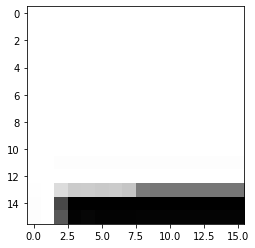

In [32]:
# Display a patch that belongs to the foreground class
plt.imshow(gt_patches[Y1[100]], cmap='Greys_r')

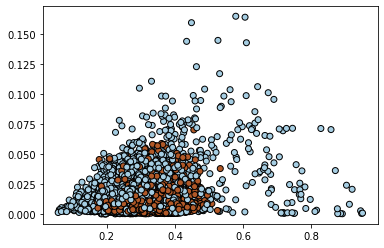

In [10]:
# Plot 2d features using groundtruth to color the datapoints
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)

In [11]:
# train a logistic regression classifier

from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X, Y)

LogisticRegression(C=100000.0, class_weight='balanced')

In [12]:
# Predict on the training set
Z = logreg.predict(X)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
print('True positive rate = ' + str(TPR))

True positive rate = 0.19296


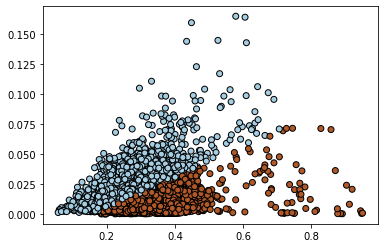

In [13]:
# Plot features using predictions to color datapoints
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)

In [14]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

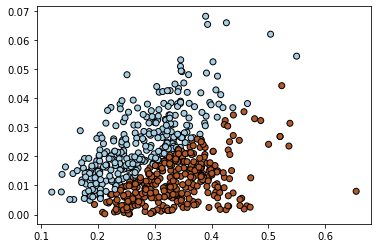

In [15]:
# Run prediction on the img_idx-th image
img_idx = 12

Xi = extract_img_features(image_dir + files[img_idx])
Zi = logreg.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

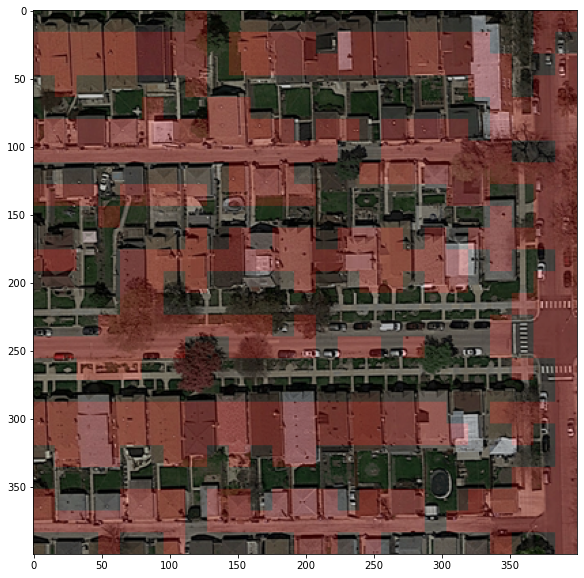

In [16]:
# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)
